## Machine Learning test

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve

## IMPORTING THE CLEANED DATAFRAME
df_final = pd.read_csv('./CSV/df_merged_clean.csv')
#Print to ensure it is the right data frame
df_final

,Date,mean,std,volume,daily_return
0,2005-01-03,-0.500000,0.707107,2,-0.018395
1,2005-01-06,0.000000,0.000000,3,0.027972
2,2005-01-07,0.000000,0.000000,4,0.015306
3,2005-01-11,-0.333333,0.577350,3,-0.018487
4,2005-01-18,-1.000000,1.414214,2,-0.011986
...,...,...,...,...,...
1701,2023-08-07,0.000000,0.000000,3,0.028071
1702,2023-08-08,0.250000,2.179449,12,0.172622
1703,2023-08-09,1.444444,2.962731,9,-0.012815
1704,2023-08-10,-0.400000,1.776388,10,-0.012189


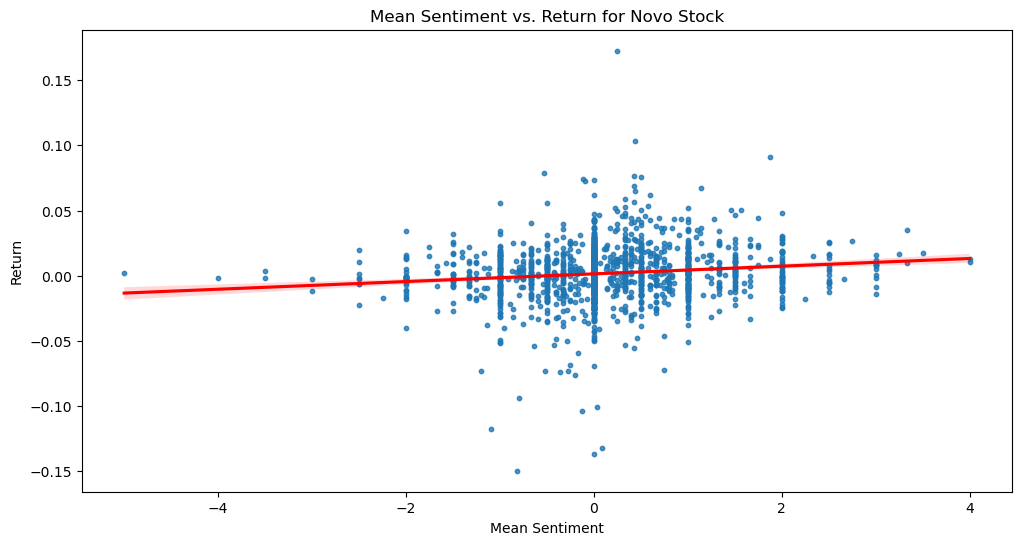

In [31]:
plt.figure(figsize=(12, 6))
sns.regplot(x='mean', y='daily_return', data=df_final, ci=95, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('Mean Sentiment vs. Return for Novo Stock')
plt.xlabel('Mean Sentiment')
plt.ylabel('Return')
plt.show()

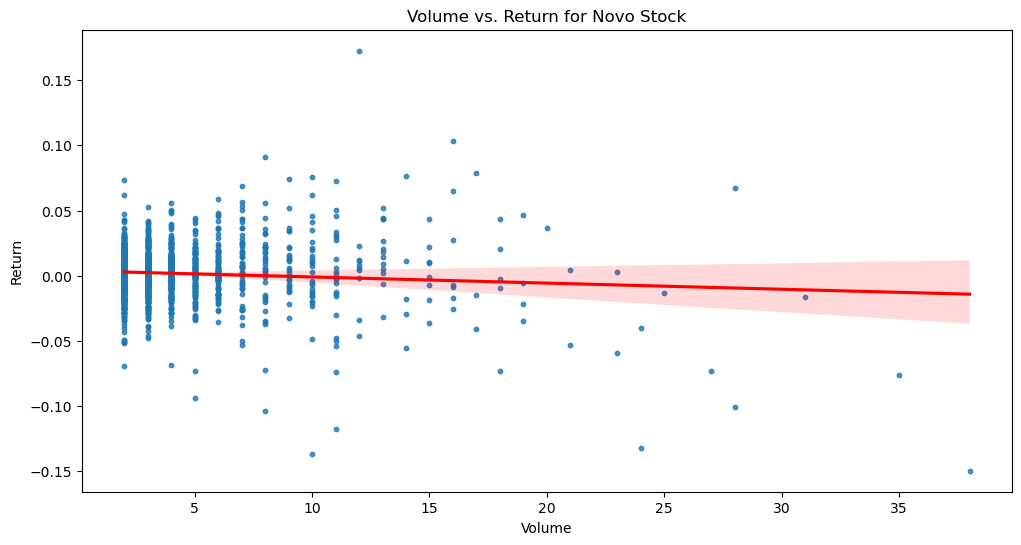

In [33]:
plt.figure(figsize=(12, 6))
sns.regplot(x='volume', y='daily_return', data=df_final, ci=95, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('Volume vs. Return for Novo Stock')
plt.xlabel('Volume')
plt.ylabel('Return')
plt.show()

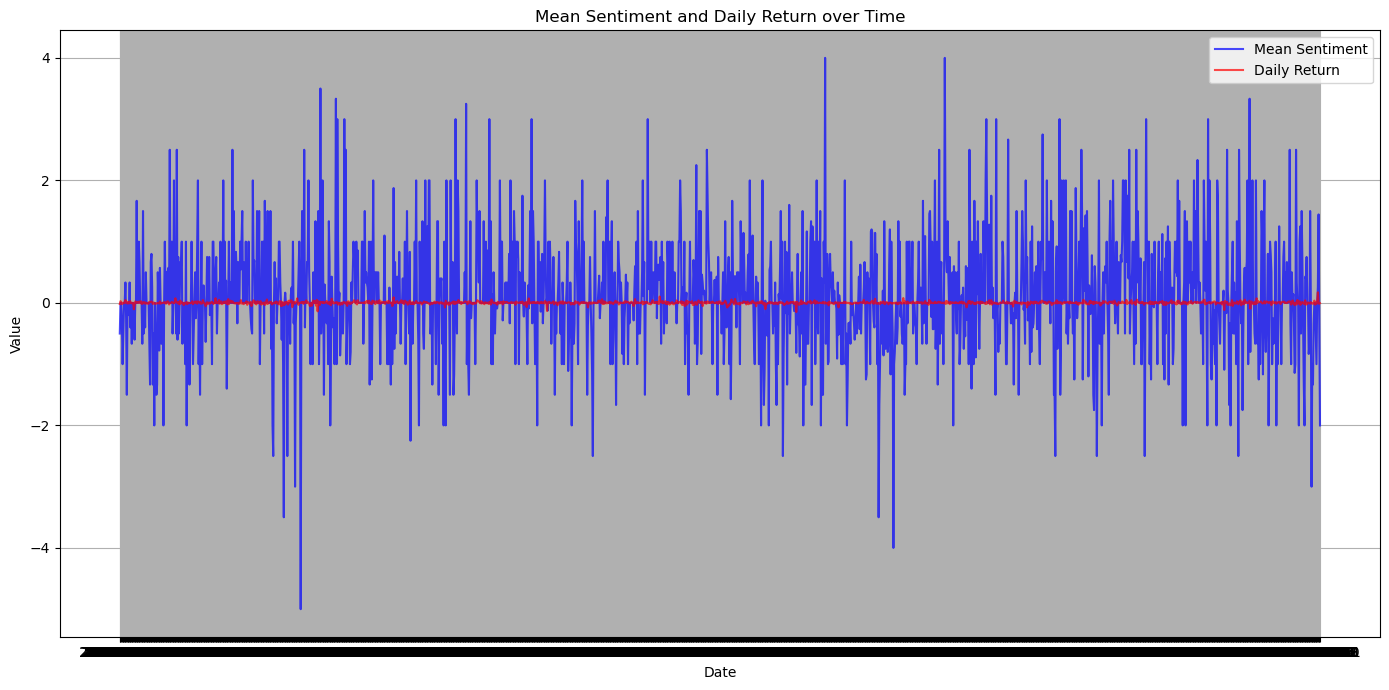

In [36]:
plt.figure(figsize=(14, 7))

# Plot Mean Sentiment
plt.plot(df_final['Date'], df_final['mean'], label='Mean Sentiment', color='blue', alpha=0.7)
# Plot Daily Return
plt.plot(df_final['Date'], df_final['daily_return'], label='Daily Return', color='red', alpha=0.7)

plt.title('Mean Sentiment and Daily Return over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
# Splitting the data into features and target variable
X = df_final[['mean', 'std', 'volume']]  # Features
y = df_final['daily_return']  # Target variable

In [4]:
# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=161193)

In [16]:
#Linear regression 
# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [27]:
##Construct a model building pipeline which adds polynomial features of degree 3 without bias; scales the features to mean zero and unit std.; estimates a Lasso model
# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-4, 4, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=161193))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.8f' % optimal.values[0])

Optimal lambda: 0.0004124626382901352
Validation MSE: 0.00069651


In [19]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

# COMPARE MODEL PERFORMANCE ON TEST DATA
print('Lasso', round(mse(pipe_lasso.predict(X_test),y_test), 8))
print('LinReg', round(mse(pipe_lr.predict(X_test),y_test), 8))

Lasso 0.00031938
LinReg 0.00032274


In [24]:
# SETUPa
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=161193))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # Store result    
    mseCV.append(mseCV_) 
    
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)

In [26]:
# CHOOSE OPTIMAL HYPERPARAMETERS (mean of MSE's across folds)
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)

# RETRAIN/RE-ESTIMATE MODEL USING OPTIMAL HYPERPARAMETERS AND COMPARE PERFORMANCE
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=161193))

pipe_lassoCV.fit(X_dev,y_dev) #fit optimal lambda to entire development set: likely to improve performance slightly since we use more oberservations

models = {'Lasso': pipe_lasso, 'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 8))

Lasso 0.00031938
Lasso CV 0.00031959
LinReg 0.00032274


       train      test        lambda
0   0.000411  0.000430      0.000100
1   0.000420  0.000434      0.000534
2   0.000435  0.000448      0.002848
3   0.000479  0.000480      0.015199
4   0.000479  0.000480      0.081113
5   0.000479  0.000480      0.432876
6   0.000479  0.000480      2.310130
7   0.000479  0.000480     12.328467
8   0.000479  0.000480     65.793322
9   0.000479  0.000480    351.119173
10  0.000479  0.000480   1873.817423
11  0.000479  0.000480  10000.000000


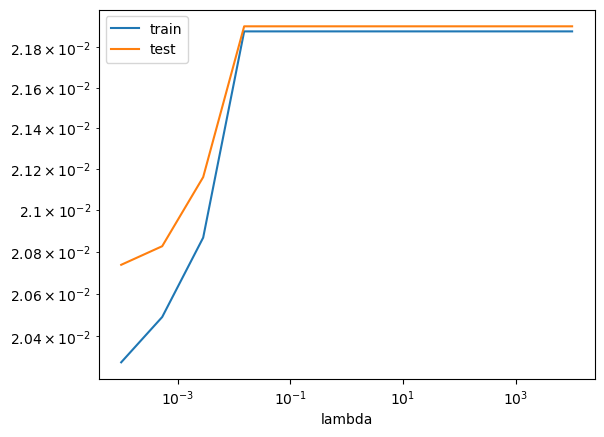

In [14]:
lambdas =  np.logspace(-4, 4, 12)

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',# scoring='neg_mean_squared_error',                 
                     cv=10)

mean_values = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'lambda': pd.DataFrame(lambdas).mean(1)}, axis =1)

print(mean_values)

# Plotting
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))


# plot curves
pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambdas, name='lambda'))\
    .plot(logx=True, logy=True)

plt.show()

### END SOLUTION


In [ ]:
# CHOOSE OPTIMAL HYPERPARAMETERS (mean of MSE's across folds)
optimal_lambda = mean_values.mean(axis=1).nsmallest(1)

# RETRAIN/RE-ESTIMATE MODEL USING OPTIMAL HYPERPARAMETERS AND COMPARE PERFORMANCE
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=161193))

pipe_lassoCV.fit(X_dev,y_dev) #fit optimal lambda to entire development set: likely to improve performance slightly since we use more oberservations

models = {'Lasso': pipe_lasso, 'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 2))

In [ ]:
models = {'Lasso': pipe_lasso, 'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 2))

In [15]:
from sklearn.model_selection import validation_curve

# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=10)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
0.0001    0.00043
Name: Validation, dtype: float64
